In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WAP     462 non-null    float64
dtypes: float64(1)
memory usage: 3.7 KB


<Axes: >

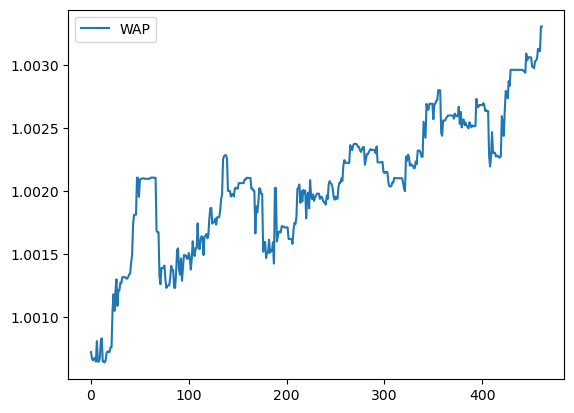

In [2]:
df = pd.read_csv("./individual_book_train/stock_53.csv")
df['WAP'] = (df['bid_price1']*df['ask_size1'] + df['ask_price1']*df['bid_size1']) /\
    (df['bid_size1'] + df['ask_size1'])
df_filtered = df[df['time_id'] == 18944][['WAP']]
df_filtered = df_filtered.reset_index(drop=True)

df_filtered.info()
df_filtered.plot()

The plot visually seems linearly growing.

In [3]:
X = df_filtered.index.values.reshape(-1, 1)
y = df_filtered['WAP']

##### Linear regression

In [4]:
model = LinearRegression().fit(X, y)
m = model.coef_[0]
b = model.intercept_

print(f"y = {m:.2e}x + {b:.5}")

y = 3.65e-06x + 1.0012


This is the predicted regression model for this data frame.

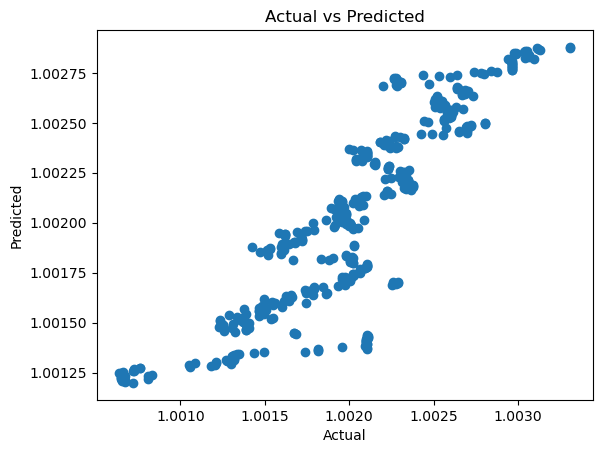

In [5]:
y_pred = model.predict(X)
plt.scatter(y, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [6]:
r_squared_train = model.score(X, y)
mapeline = mean_absolute_percentage_error(y, y_pred)
print(f'R-squared value: {r_squared_train:.2f}')
print(f'Mean Absolute Percentage Error - linear: {mapeline}')

R-squared value: 0.77
Mean Absolute Percentage Error - linear: 0.000203028433345215


##### Polynomial Regression

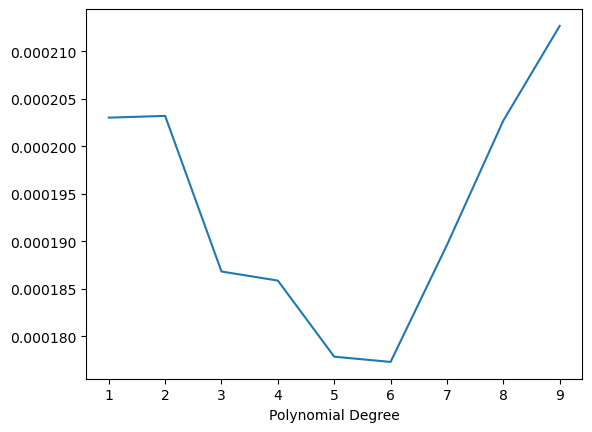

Minimum MAPE: 1.77e-04 at degree: 6
Maximum R-squared value: 0.84 at degree: 5


In [7]:
r_squared_values = []
mape_values = []

for degree in range(1, 10):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    
    model = LinearRegression().fit(X_poly, y)
    
    r_squared = model.score(X_poly, y)
    r_squared_values.append(r_squared)
    
    y_pred = model.predict(X_poly)
    mape = mean_absolute_percentage_error(y_true=y, y_pred=y_pred)
    mape_values.append(mape)


degrees = np.arange(1, 10)
plt.plot(degrees, mape_values)
plt.xlabel('Polynomial Degree')
plt.show()

min_mape = min(mape_values)
min_degree = degrees[mape_values.index(min_mape)]
print(f"Minimum MAPE: {min_mape:.2e} at degree: {min_degree}")
print(f"Maximum R-squared value: {max(r_squared_values):.2f} at degree: {degrees[r_squared_values.index(max(r_squared_values))]}")